In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

% matplotlib inline

/Users/SBG/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Read-in data

game_data = 'game_data.csv'
player_data = 'player_data.csv'
training_set = 'training_set.csv'
test_set = 'test_set.csv'

game = pd.read_csv(game_data)
player = pd.read_csv(player_data)
training = pd.read_csv(training_set)

In [3]:
# lowercase columns

game.columns = [x.lower() for x in game.columns]
player.columns = [x.lower() for x in player.columns]
training.columns = [x.lower() for x in training.columns]

# another option

#game.columns = map(str.lower, game.columns)


## Training Data

In [4]:
training.head()

,season,game_id,game_date,away_team,home_team,country,rounded viewers
0,2016-17,21600001,10/25/16,NYK,CLE,C113,18
1,2016-17,21600001,10/25/16,NYK,CLE,C193,1
2,2016-17,21600001,10/25/16,NYK,CLE,C126,4
3,2016-17,21600001,10/25/16,NYK,CLE,C163,11
4,2016-17,21600001,10/25/16,NYK,CLE,C73,3


In [5]:
training.shape

(280625, 7)

Training data is broken down by country but the objective is to predict total viewers

In [6]:
# Group by game_id to get total viewers regardless of country
training.groupby(['game_id', 'season', 'game_date', 'away_team', 'home_team'])['rounded viewers'].sum().head()

game_id   season   game_date  away_team  home_team
21600001  2016-17  10/25/16   NYK        CLE          57691
21600002  2016-17  10/25/16   UTA        POR          40740
21600003  2016-17  10/25/16   SAS        GSW          60428
21600004  2016-17  10/26/16   MIA        ORL          22756
21600005  2016-17  10/26/16   DAL        IND          33922
Name: rounded viewers, dtype: int64

In [7]:
# Create dataframe of the above groupby

grouped = training.groupby(['game_id', 'season', 'game_date', 'away_team', 'home_team'])['rounded viewers'].sum().reset_index()
training_simple = pd.DataFrame(grouped)
training_simple.head()

,game_id,season,game_date,away_team,home_team,rounded viewers
0,21600001,2016-17,10/25/16,NYK,CLE,57691
1,21600002,2016-17,10/25/16,UTA,POR,40740
2,21600003,2016-17,10/25/16,SAS,GSW,60428
3,21600004,2016-17,10/26/16,MIA,ORL,22756
4,21600005,2016-17,10/26/16,DAL,IND,33922


## Player Data

In [8]:
player.head()

,season,game_id,game_date,team,person_id,name,asg_team,active_status,minutes,points,...,steals,blocks,turnovers,field_goals,field_goals_attempted,three_pointers,three_pointers_attempted,free_throws,free_throws_attempted,personal_fouls
0,2016-17,21600001,10/25/16,CLE,101112,Channing Frye,None,Active,14.0,6.0,...,1.0,1.0,1.0,2.0,6.0,2.0,5.0,0.0,0.0,4.0
1,2016-17,21600001,10/25/16,CLE,201567,Kevin Love,East ASG,Active,25.0,23.0,...,3.0,0.0,2.0,6.0,15.0,2.0,6.0,9.0,12.0,3.0
2,2016-17,21600001,10/25/16,CLE,202681,Kyrie Irving,East ASG,Active,30.0,29.0,...,2.0,0.0,0.0,12.0,22.0,4.0,7.0,1.0,1.0,1.0
3,2016-17,21600001,10/25/16,CLE,202684,Tristan Thompson,None,Active,22.0,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
4,2016-17,21600001,10/25/16,CLE,202697,Iman Shumpert,None,Active,14.0,2.0,...,0.0,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0


In [9]:
player.shape

(77392, 23)

The only data here that also exists in our test set has to to do with all stars and active

In [10]:
# Create numerical asg category factoring in active status
player['all_stars_active'] = np.where((player.asg_team.str.contains('ASG')) & (player.active_status == 'Active'),1,0)

In [11]:
#Create data frame of all stars active
grouped = player.groupby('game_id').all_stars_active.sum().reset_index()
all_stars = pd.DataFrame(grouped)
all_stars.head()

,game_id,all_stars_active
0,21600001,4
1,21600002,0
2,21600003,5
3,21600004,0
4,21600005,1


## Merge Dataframes and Clean 

In [12]:
#Merge dataframes
df = pd.merge(training_simple, all_stars)

#Rename rounded viewers to viewer
df['viewers'] = df['rounded viewers']
df.drop('rounded viewers', axis = 1, inplace=True)

#Set index to game_id
df.set_index('game_id', inplace=True)
df.head()

,season,game_date,away_team,home_team,all_stars_active,viewers
game_id,,,,,,
21600001,2016-17,10/25/16,NYK,CLE,4,57691
21600002,2016-17,10/25/16,UTA,POR,0,40740
21600003,2016-17,10/25/16,SAS,GSW,5,60428
21600004,2016-17,10/26/16,MIA,ORL,0,22756
21600005,2016-17,10/26/16,DAL,IND,1,33922


In [13]:
df.shape

(2000, 6)

In [14]:
df.dtypes

season              object
game_date           object
away_team           object
home_team           object
all_stars_active     int64
viewers              int64
dtype: object

In [15]:
# Convert game_date to datetime
df['game_date'] = pd.to_datetime(df.game_date)

# Create seperate columns for month, week # and day of the week
df['month'], df['week'], df['dow'] = df.game_date.dt.month, df.game_date.dt.week, df.game_date.dt.weekday_name

df.head(10)

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow
game_id,,,,,,,,,
21600001,2016-17,2016-10-25,NYK,CLE,4,57691,10,43,Tuesday
21600002,2016-17,2016-10-25,UTA,POR,0,40740,10,43,Tuesday
21600003,2016-17,2016-10-25,SAS,GSW,5,60428,10,43,Tuesday
21600004,2016-17,2016-10-26,MIA,ORL,0,22756,10,43,Wednesday
21600005,2016-17,2016-10-26,DAL,IND,1,33922,10,43,Wednesday
21600006,2016-17,2016-10-26,BKN,BOS,1,23947,10,43,Wednesday
21600007,2016-17,2016-10-26,DET,TOR,2,14887,10,43,Wednesday
21600008,2016-17,2016-10-26,CHA,MIL,2,12046,10,43,Wednesday
21600009,2016-17,2016-10-26,MIN,MEM,1,21853,10,43,Wednesday


In [16]:
df.dtypes

season                      object
game_date           datetime64[ns]
away_team                   object
home_team                   object
all_stars_active             int64
viewers                      int64
month                        int64
week                         int64
dow                         object
dtype: object

In [17]:
df.isnull().sum()

season              0
game_date           0
away_team           0
home_team           0
all_stars_active    0
viewers             0
month               0
week                0
dow                 0
dtype: int64

## Exploratory Data Analysis

In [18]:
df.head()

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow
game_id,,,,,,,,,
21600001,2016-17,2016-10-25,NYK,CLE,4,57691,10,43,Tuesday
21600002,2016-17,2016-10-25,UTA,POR,0,40740,10,43,Tuesday
21600003,2016-17,2016-10-25,SAS,GSW,5,60428,10,43,Tuesday
21600004,2016-17,2016-10-26,MIA,ORL,0,22756,10,43,Wednesday
21600005,2016-17,2016-10-26,DAL,IND,1,33922,10,43,Wednesday


In [19]:
df.viewers.describe()

count     2000.000000
mean     16967.709500
std      10906.922749
min       1899.000000
25%       9328.500000
50%      14271.500000
75%      21841.750000
max      89246.000000
Name: viewers, dtype: float64

### Month

In [20]:
df.month.value_counts()

3     381
12    371
11    363
1     343
2     261
4     154
10    127
Name: month, dtype: int64

In [21]:
df.groupby('month').viewers.mean().sort_values(ascending=False)

month
10    26877.960630
11    19631.377410
1     17001.851312
12    16159.407008
2     15392.463602
3     14287.091864
4     13689.207792
Name: viewers, dtype: float64

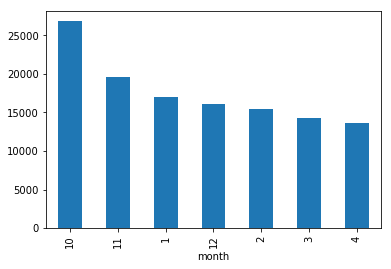

In [22]:
df.groupby('month').viewers.mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

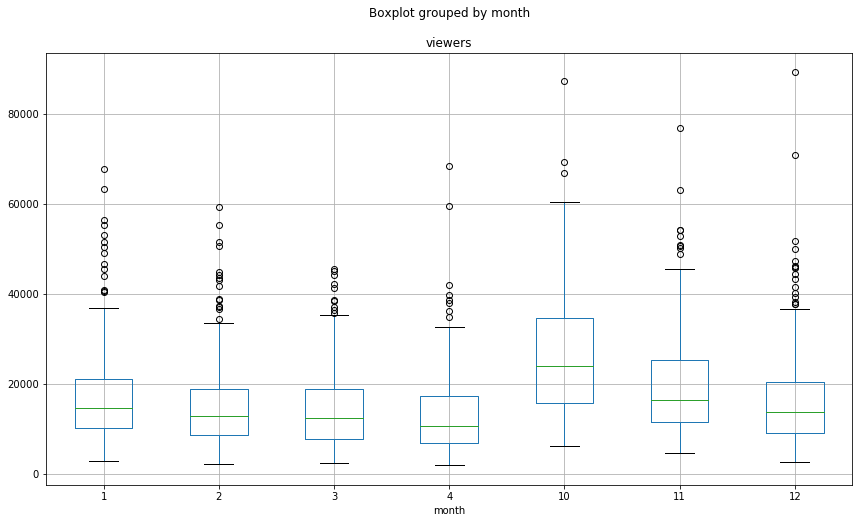

In [23]:
df.boxplot(column = 'viewers', by='month', figsize = (14,8))
plt.show()

### Week

In [24]:
df.week.value_counts()

10    90
12    90
47    89
49    88
14    87
11    87
1     86
6     86
51    85
13    85
50    84
9     83
44    82
48    82
45    81
52    81
43    80
3     80
46    79
4     79
5     77
2     68
7     49
8     45
15    44
42    33
Name: week, dtype: int64

In [25]:
df.groupby('week').viewers.mean().sort_values(ascending=False)

week
42    30199.333333
43    26479.687500
45    21711.530864
44    21664.804878
46    19437.088608
2     18404.985294
48    18274.170732
49    18140.534091
3     18125.762500
47    17513.011236
8     16838.866667
1     16400.872093
4     16347.227848
6     15746.627907
5     15291.727273
52    15067.111111
50    14953.738095
51    14914.505882
9     14749.433735
11    14710.068966
13    14048.952941
10    13974.811111
12    13909.900000
14    13717.586207
7     13622.367347
15    13417.727273
Name: viewers, dtype: float64

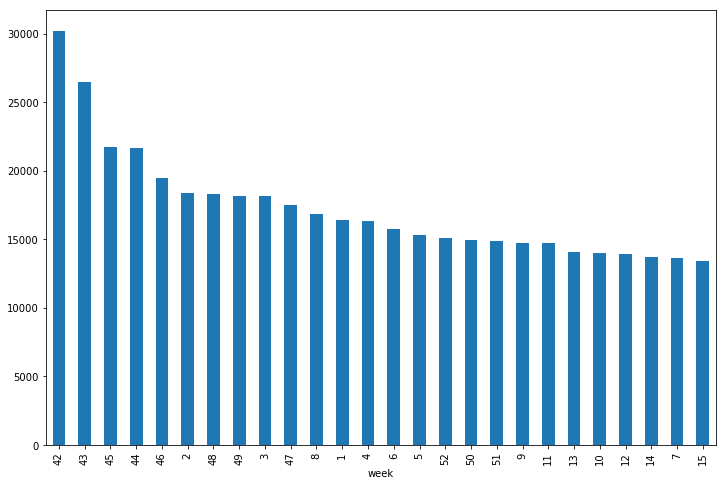

In [26]:
df.groupby('week').viewers.mean().sort_values(ascending=False).plot(kind='bar', figsize = (12,8))
plt.show()

In [27]:
#Recode week of year to week of season because season started on different weeks of the year

conditions = [(df['week'] == 43) & (df['season'] == '2016-17'),(df['week'] == 44) & (df['season'] == '2016-17'),
(df['week'] == 45) & (df['season'] == '2016-17'),(df['week'] == 46) & (df['season'] == '2016-17'),
(df['week'] == 47) & (df['season'] == '2016-17'),(df['week'] == 48) & (df['season'] == '2016-17'),
(df['week'] == 49) & (df['season'] == '2016-17'),(df['week'] == 50) & (df['season'] == '2016-17'),
(df['week'] == 51) & (df['season'] == '2016-17'),(df['week'] == 52) & (df['season'] == '2016-17'),
(df['week'] == 1) & (df['season'] == '2016-17'),(df['week'] == 2) & (df['season'] == '2016-17'),
(df['week'] == 3) & (df['season'] == '2016-17'),(df['week'] == 4) & (df['season'] == '2016-17'),
(df['week'] == 5) & (df['season'] == '2016-17'),(df['week'] == 6) & (df['season'] == '2016-17'),
(df['week'] == 7) & (df['season'] == '2016-17'),(df['week'] == 8) & (df['season'] == '2016-17'),
(df['week'] == 9) & (df['season'] == '2016-17'),(df['week'] == 10) & (df['season'] == '2016-17'),
(df['week'] == 11) & (df['season'] == '2016-17'),(df['week'] == 12) & (df['season'] == '2016-17'),
(df['week'] == 13) & (df['season'] == '2016-17'),(df['week'] == 14) & (df['season'] == '2016-17'),
(df['week'] == 15) & (df['season'] == '2016-17'),(df['week'] == 42) & (df['season'] == '2017-18'),
(df['week'] == 43) & (df['season'] == '2017-18'),(df['week'] == 44) & (df['season'] == '2017-18'),
(df['week'] == 45) & (df['season'] == '2017-18'),(df['week'] == 46) & (df['season'] == '2017-18'),
(df['week'] == 47) & (df['season'] == '2017-18'),(df['week'] == 48) & (df['season'] == '2017-18'),
(df['week'] == 49) & (df['season'] == '2017-18'),(df['week'] == 50) & (df['season'] == '2017-18'),
(df['week'] == 51) & (df['season'] == '2017-18'),(df['week'] == 52) & (df['season'] == '2017-18'),
(df['week'] == 1) & (df['season'] == '2017-18'),(df['week'] == 2) & (df['season'] == '2017-18'),
(df['week'] == 3) & (df['season'] == '2017-18'),(df['week'] == 4) & (df['season'] == '2017-18'),
(df['week'] == 5) & (df['season'] == '2017-18'),(df['week'] == 6) & (df['season'] == '2017-18'),
(df['week'] == 7) & (df['season'] == '2017-18'),(df['week'] == 8) & (df['season'] == '2017-18'),
(df['week'] == 9) & (df['season'] == '2017-18'),(df['week'] == 10) & (df['season'] == '2017-18'),
(df['week'] == 11) & (df['season'] == '2017-18'),(df['week'] == 12) & (df['season'] == '2017-18'),
(df['week'] == 13) & (df['season'] == '2017-18'),(df['week'] == 14) & (df['season'] == '2017-18'),
(df['week'] == 15) & (df['season'] == '2017-18')]
    
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
df['week_season'] = np.select(conditions, choices, default =0)

In [28]:
df.groupby('week_season').viewers.mean()

week_season
1     29941.300000
2     23202.250000
3     20978.061728
4     20532.809524
5     19269.506173
6     17312.666667
7     18560.627907
8     16597.216867
9     14031.456790
10    13974.379310
11    16592.730337
12    18700.112676
13    18648.623377
14    16360.881579
15    15945.410256
16    14972.049383
17    14716.528571
18    16333.104167
19    16088.387097
20    13649.120879
21    13996.423529
22    14625.921348
23    13895.584270
24    14104.226190
25    12708.878788
26    16388.450000
Name: viewers, dtype: float64

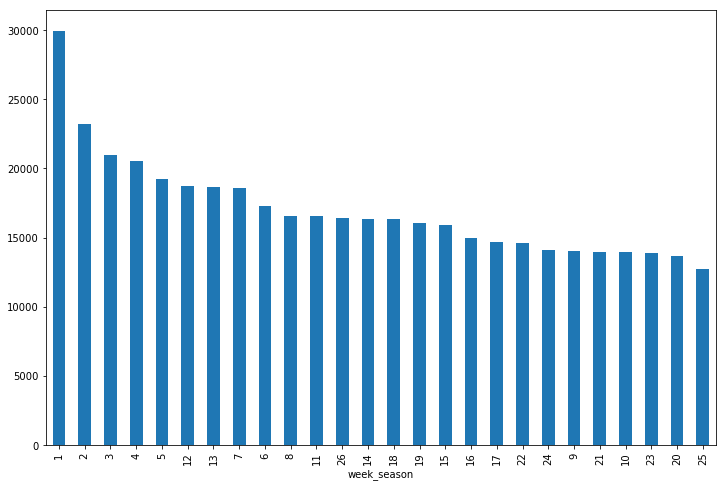

In [29]:
df.groupby('week_season').viewers.mean().sort_values(ascending=False).plot(kind='bar', figsize=(12,8))
plt.show()

### Day

In [30]:
df.dow.value_counts()

Wednesday    392
Friday       352
Saturday     298
Monday       290
Tuesday      255
Sunday       235
Thursday     178
Name: dow, dtype: int64

In [31]:
df.groupby('dow').viewers.mean().sort_values(ascending=False)

dow
Thursday     20862.146067
Sunday       18287.272340
Tuesday      17485.631373
Saturday     17376.184564
Friday       16564.732955
Monday       16268.482759
Wednesday    14639.956633
Name: viewers, dtype: float64

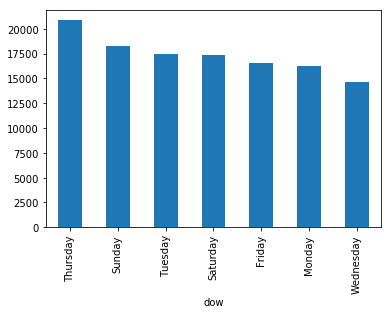

In [32]:
df.groupby('dow').viewers.mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

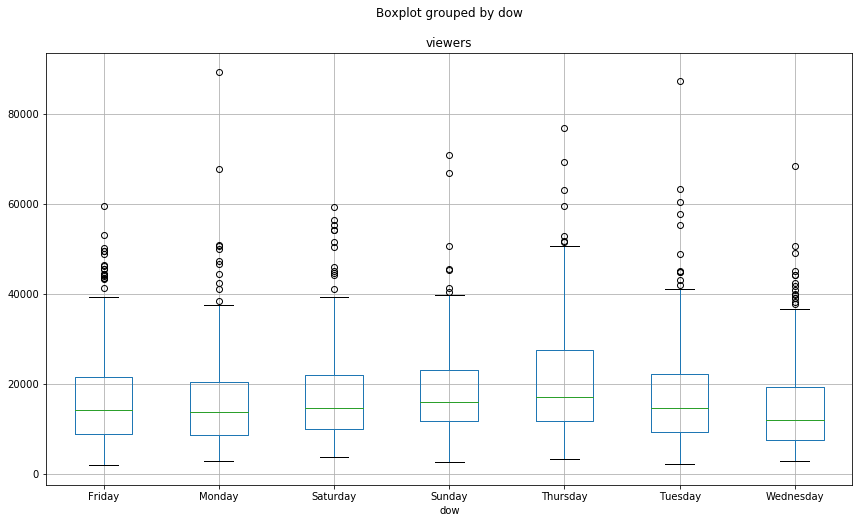

In [33]:
df.boxplot(column = 'viewers', by='dow', figsize = (14,8))
plt.show()

In [34]:
#Create numerical category for dow
df['day_num'] = df.dow.map({'Monday': 1, 'Tuesday':2, 'Wednesday': 3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday': 7})

### All Stars

In [35]:
df.all_stars_active.value_counts()

1    717
2    592
0    327
3    208
4    100
5     41
6     13
7      2
Name: all_stars_active, dtype: int64

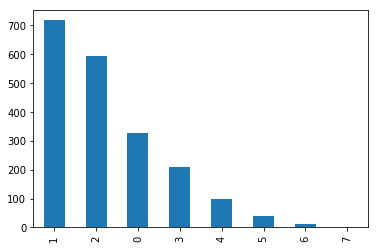

In [36]:
df.all_stars_active.value_counts().plot(kind='bar')
plt.show()

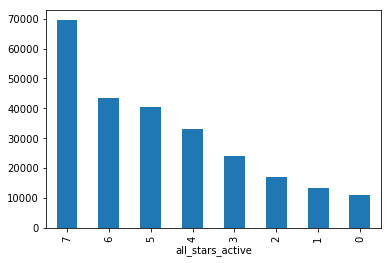

In [37]:
#Average viewers by # of all stars
df.groupby('all_stars_active').viewers.mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

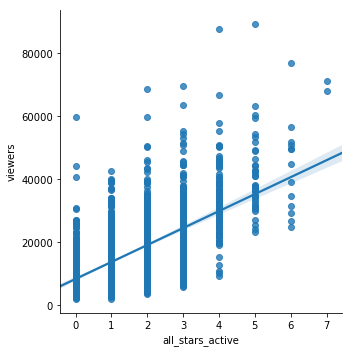

In [38]:
sns.lmplot(x='all_stars_active', y='viewers', data=df)
plt.show()

### Season

In [39]:
df.season.value_counts()

2016-17    1013
2017-18     987
Name: season, dtype: int64

In [40]:
df.groupby('season').viewers.mean()

season
2016-17    16774.337611
2017-18    17166.175279
Name: viewers, dtype: float64

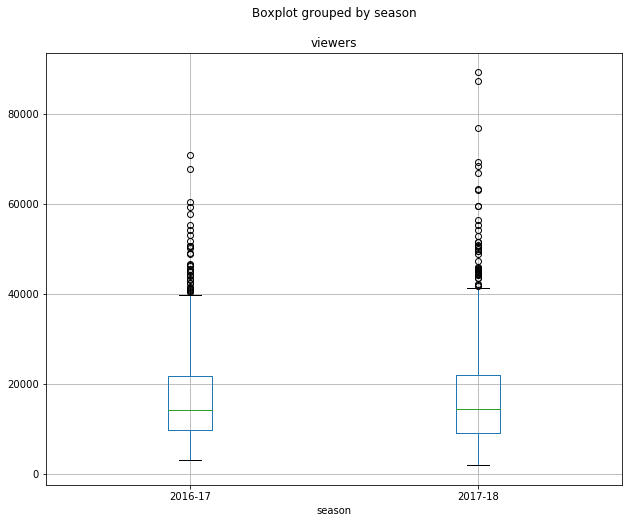

In [41]:
df.boxplot(column = 'viewers', by='season', figsize = (10,8))
plt.show()

### Teams

In [42]:
#Create list of all teams

teams = df.home_team.unique()
teams = teams.tolist()

# Check all teams are represented
len(teams)

30

In [43]:
# create dictionary with teams average viewership using for loop

views = []
for team in teams:
    avg_viewers = df[(df['home_team']==team) | (df['away_team'] ==team)].viewers.mean()
    views.append(round(avg_viewers))

team_viewers = {'teams': teams,
               'views': views}

# Convert to Dataframe

team_viewers = pd.DataFrame(team_viewers)
team_viewers.sort_values(by='views', ascending=False)

,teams,views
0,CLE,34748
2,GSW,34576
17,OKC,25807
5,BOS,22926
11,LAL,21512
25,HOU,19869
22,SAS,19676
9,PHI,19599
21,NYK,17972
26,MIN,16819


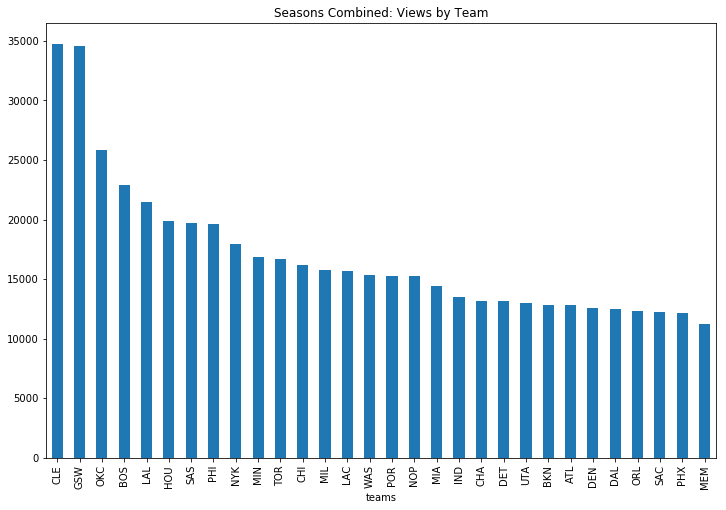

In [44]:
team_viewers.sort_values(by='views', ascending=False).plot(kind='bar', x='teams', y='views', figsize=(12,8), legend=False)
plt.title('Seasons Combined: Views by Team')
plt.show()

What if we look at season seperately though

In [45]:
# create dictionary with teams average viewership for 2017 season using for loop

views_2017 = []
for team in teams:
    avg_viewers_2017 = df[((df['home_team']==team) | (df['away_team'] ==team)) & (df['season'] == '2016-17')].viewers.mean()
    views_2017.append(round(avg_viewers_2017))
    

team_viewers_2017 = {'season': '2016-17','teams': teams,
               'views': views_2017}

# Convert to Dataframe

team_viewers_2017 = pd.DataFrame(team_viewers_2017)

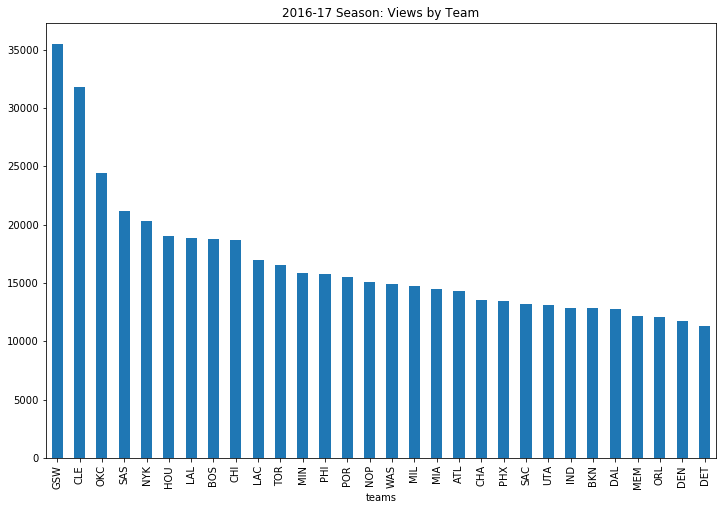

In [46]:
team_viewers_2017.sort_values(by='views', ascending=False).plot(kind='bar', x='teams', y='views', figsize=(12,8), legend=False)
plt.title('2016-17 Season: Views by Team')
plt.show()

In [47]:
# create dictionary with teams average viewership using for loop

views_2018 = []
for team in teams:
    avg_viewers_2018 = df[((df['home_team']==team) | (df['away_team'] ==team)) & (df['season'] == '2017-18')].viewers.mean()
    views_2018.append(round(avg_viewers_2018))
    

team_viewers_2018 = {'season': '2017-18','teams': teams,
               'views': views_2018}

# Convert to Dataframe

team_viewers_2018 = pd.DataFrame(team_viewers_2018)

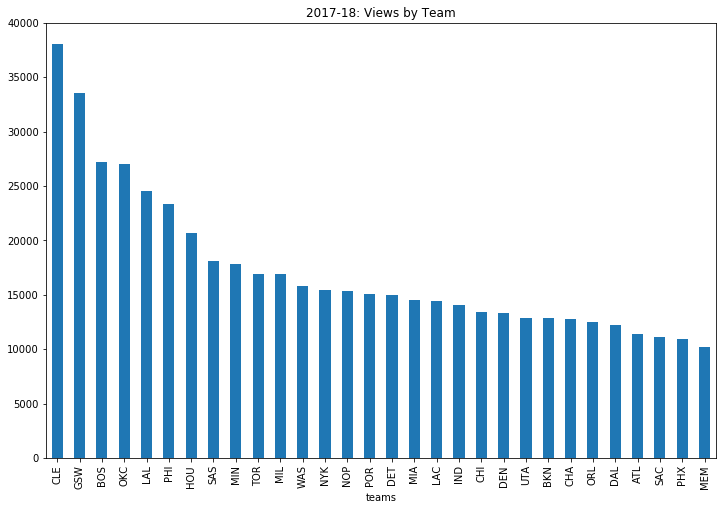

In [48]:
team_viewers_2018.sort_values(by='views', ascending=False).plot(kind='bar', x='teams', y='views', figsize=(12,8), legend=False)
plt.title('2017-18: Views by Team')
plt.show()


In [49]:
#Subtract average viewers from each season to see any major differences

views_diff = pd.merge(team_viewers_2017, team_viewers_2018, on='teams')
views_diff['difference'] = views_diff.views_y - views_diff.views_x
views_diff.set_index('teams', inplace=True)
views_diff.sort_values(by='difference', ascending=False)

,season_x,views_x,season_y,views_y,difference
teams,,,,,
BOS,2016-17,18736,2017-18,27249,8513
PHI,2016-17,15784,2017-18,23353,7569
CLE,2016-17,31758,2017-18,38081,6323
LAL,2016-17,18873,2017-18,24540,5667
DET,2016-17,11283,2017-18,14973,3690
OKC,2016-17,24421,2017-18,27057,2636
MIL,2016-17,14759,2017-18,16883,2124
MIN,2016-17,15816,2017-18,17866,2050
HOU,2016-17,19030,2017-18,20719,1689


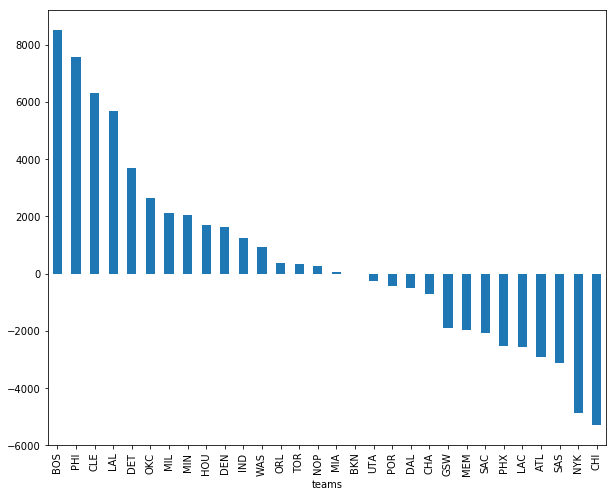

In [50]:
views_diff.difference.sort_values(ascending=False).plot(kind='bar', figsize=(10,8))
plt.show()

# Feature Engineering

In [51]:
views_combined = pd.merge(team_viewers_2017, team_viewers_2018)
team_viewers = team_viewers_2017.append(team_viewers_2018)
team_viewers.reset_index().sort_values(by='views', ascending=False)

,index,season,teams,views
30,0,2017-18,CLE,38081
2,2,2016-17,GSW,35505
32,2,2017-18,GSW,33591
0,0,2016-17,CLE,31758
35,5,2017-18,BOS,27249
47,17,2017-18,OKC,27057
41,11,2017-18,LAL,24540
17,17,2016-17,OKC,24421
39,9,2017-18,PHI,23353
22,22,2016-17,SAS,21188


In [52]:
conditions = [(df['home_team'] == 'CLE') & (df['season'] == '2017-18'),(df['home_team'] == 'GSW') & (df['season'] == '2016-17'),
             (df['home_team'] == 'GSW') & (df['season'] == '2017-18'),(df['home_team'] == 'CLE') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BOS') & (df['season'] == '2017-18'),(df['home_team'] == 'OKC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'LAL') & (df['season'] == '2017-18'),(df['home_team'] == 'OKC') & (df['season'] == '2016-17'),
             (df['home_team'] == 'PHI') & (df['season'] == '2017-18'),(df['home_team'] == 'SAS') & (df['season'] == '2016-17'),
             (df['home_team'] == 'HOU') & (df['season'] == '2017-18'),(df['home_team'] == 'NYK') & (df['season'] == '2016-17'),
             (df['home_team'] == 'HOU') & (df['season'] == '2016-17'),(df['home_team'] == 'LAL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BOS') & (df['season'] == '2016-17'),(df['home_team'] == 'CHI') & (df['season'] == '2016-17'),
             (df['home_team'] == 'SAS') & (df['season'] == '2017-18'),(df['home_team'] == 'MIN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'LAC') & (df['season'] == '2016-17'),(df['home_team'] == 'TOR') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MIL') & (df['season'] == '2017-18'),(df['home_team'] == 'TOR') & (df['season'] == '2016-17'),
             (df['home_team'] == 'MIN') & (df['season'] == '2016-17'),(df['home_team'] == 'WAS') & (df['season'] == '2017-18'),
             (df['home_team'] == 'PHI') & (df['season'] == '2016-17'),(df['home_team'] == 'POR') & (df['season'] == '2016-17'),
             (df['home_team'] == 'NYK') & (df['season'] == '2017-18'),(df['home_team'] == 'NOP') & (df['season'] == '2017-18'),
             (df['home_team'] == 'NOP') & (df['season'] == '2016-17'),(df['home_team'] == 'POR') & (df['season'] == '2017-18'),
             (df['home_team'] == 'DET') & (df['season'] == '2017-18'),(df['home_team'] == 'WAS') & (df['season'] == '2016-17'),
             (df['home_team'] == 'MIL') & (df['season'] == '2016-17'),(df['home_team'] == 'MIA') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MIA') & (df['season'] == '2016-17'),(df['home_team'] == 'LAC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'ATL') & (df['season'] == '2016-17'),(df['home_team'] == 'IND') & (df['season'] == '2017-18'),
             (df['home_team'] == 'CHA') & (df['season'] == '2016-17'),(df['home_team'] == 'PHX') & (df['season'] == '2016-17'),
             (df['home_team'] == 'CHI') & (df['season'] == '2017-18'),(df['home_team'] == 'DEN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'SAC') & (df['season'] == '2016-17'),(df['home_team'] == 'UTA') & (df['season'] == '2016-17'),
             (df['home_team'] == 'UTA') & (df['season'] == '2017-18'),(df['home_team'] == 'IND') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BKN') & (df['season'] == '2016-17'),(df['home_team'] == 'BKN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'CHA') & (df['season'] == '2017-18'),(df['home_team'] == 'DAL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'ORL') & (df['season'] == '2017-18'),(df['home_team'] == 'DAL') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MEM') & (df['season'] == '2016-17'),(df['home_team'] == 'ORL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'DEN') & (df['season'] == '2016-17'),(df['home_team'] == 'ATL') & (df['season'] == '2017-18'),
             (df['home_team'] == 'DET') & (df['season'] == '2016-17'),(df['home_team'] == 'SAC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'PHX') & (df['season'] == '2017-18'),(df['home_team'] == 'MEM') & (df['season'] == '2017-18')]
             


choices = [60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
df['home_team_cat1'] = np.select(conditions, choices, default=0)

In [53]:
conditions = [(df['away_team'] == 'CLE') & (df['season'] == '2017-18'),
             (df['away_team'] == 'GSW') & (df['season'] == '2016-17'),(df['away_team'] == 'GSW') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CLE') & (df['season'] == '2016-17'),(df['away_team'] == 'BOS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'OKC') & (df['season'] == '2017-18'),(df['away_team'] == 'LAL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'OKC') & (df['season'] == '2016-17'),(df['away_team'] == 'PHI') & (df['season'] == '2017-18'),
             (df['away_team'] == 'SAS') & (df['season'] == '2016-17'),(df['away_team'] == 'HOU') & (df['season'] == '2017-18'),
             (df['away_team'] == 'NYK') & (df['season'] == '2016-17'),(df['away_team'] == 'HOU') & (df['season'] == '2016-17'),
             (df['away_team'] == 'LAL') & (df['season'] == '2016-17'),(df['away_team'] == 'BOS') & (df['season'] == '2016-17'),
             (df['away_team'] == 'CHI') & (df['season'] == '2016-17'),(df['away_team'] == 'SAS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MIN') & (df['season'] == '2017-18'),(df['away_team'] == 'LAC') & (df['season'] == '2016-17'),
             (df['away_team'] == 'TOR') & (df['season'] == '2017-18'),(df['away_team'] == 'MIL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'TOR') & (df['season'] == '2016-17'),
             (df['away_team'] == 'MIN') & (df['season'] == '2016-17'),(df['away_team'] == 'WAS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'PHI') & (df['season'] == '2016-17'),(df['away_team'] == 'POR') & (df['season'] == '2016-17'),
             (df['away_team'] == 'NYK') & (df['season'] == '2017-18'),(df['away_team'] == 'NOP') & (df['season'] == '2017-18'),
             (df['away_team'] == 'NOP') & (df['season'] == '2016-17'),(df['away_team'] == 'POR') & (df['season'] == '2017-18'),
             (df['away_team'] == 'DET') & (df['season'] == '2017-18'),(df['away_team'] == 'WAS') & (df['season'] == '2016-17'),
             (df['away_team'] == 'MIL') & (df['season'] == '2016-17'),(df['away_team'] == 'MIA') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MIA') & (df['season'] == '2016-17'),(df['away_team'] == 'LAC') & (df['season'] == '2017-18'),
             (df['away_team'] == 'ATL') & (df['season'] == '2016-17'),(df['away_team'] == 'IND') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CHA') & (df['season'] == '2016-17'),(df['away_team'] == 'PHX') & (df['season'] == '2016-17'),
             (df['away_team'] == 'CHI') & (df['season'] == '2017-18'),(df['away_team'] == 'DEN') & (df['season'] == '2017-18'),
             (df['away_team'] == 'SAC') & (df['season'] == '2016-17'),(df['away_team'] == 'UTA') & (df['season'] == '2016-17'),
             (df['away_team'] == 'UTA') & (df['season'] == '2017-18'),(df['away_team'] == 'IND') & (df['season'] == '2016-17'),
             (df['away_team'] == 'BKN') & (df['season'] == '2016-17'),(df['away_team'] == 'BKN') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CHA') & (df['season'] == '2017-18'),(df['away_team'] == 'DAL') & (df['season'] == '2016-17'),
             (df['away_team'] == 'ORL') & (df['season'] == '2017-18'),(df['away_team'] == 'DAL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MEM') & (df['season'] == '2016-17'),(df['away_team'] == 'ORL') & (df['season'] == '2016-17'),
             (df['away_team'] == 'DEN') & (df['season'] == '2016-17'),(df['away_team'] == 'ATL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'DET') & (df['season'] == '2016-17'),(df['away_team'] == 'SAC') & (df['season'] == '2017-18'),
             (df['away_team'] == 'PHX') & (df['season'] == '2017-18'),(df['away_team'] == 'MEM') & (df['season'] == '2017-18')]
             


choices = [60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

df['away_team_cat1'] = np.select(conditions, choices, default=0)

In [54]:
df['home_team1_^3'] = df['home_team_cat1'] * df['home_team_cat1'] * df['home_team_cat1']
df['away_team1_^3'] = df['away_team_cat1'] * df['away_team_cat1'] * df['away_team_cat1']
df['team_score1'] = df['home_team1_^3'] + df['away_team1_^3']

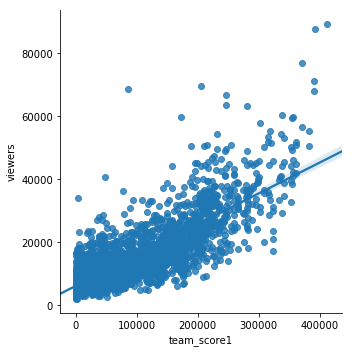

In [55]:
sns.lmplot('team_score1', 'viewers', df,)
plt.show()

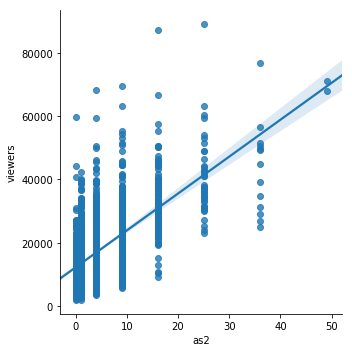

In [56]:
#Create a all stars^2 feature
df['as2'] = df.all_stars_active * df.all_stars_active
sns.lmplot(x='as2', y='viewers', data=df)
plt.show()

In [57]:
# Games on Christmas
christmas = df[(df['game_date'] == '2016-12-25') | (df['game_date'] == '2017-12-25')]
christmas

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow,week_season,day_num,home_team_cat1,away_team_cat1,home_team1_^3,away_team1_^3,team_score1,as2
game_id,,,,,,,,,,,,,,,,,
21600456,2016-17,2016-12-25,BOS,NYK,2,32984,12,51,Sunday,9,7,49,46,117649,97336,214985,4
21600457,2016-17,2016-12-25,GSW,CLE,7,70992,12,51,Sunday,9,7,57,59,185193,205379,390572,49
21600458,2016-17,2016-12-25,CHI,SAS,2,28199,12,51,Sunday,9,7,51,45,132651,91125,223776,4
21600460,2016-17,2016-12-25,LAC,LAL,1,16723,12,51,Sunday,9,7,47,42,103823,74088,177911,1
21700494,2017-18,2017-12-25,CLE,GSW,5,89246,12,52,Monday,11,1,58,60,195112,216000,411112,25
21700495,2017-18,2017-12-25,WAS,BOS,4,47365,12,52,Monday,11,1,56,37,175616,50653,226269,16
21700496,2017-18,2017-12-25,HOU,OKC,3,44524,12,52,Monday,11,1,55,50,166375,125000,291375,9
21700497,2017-18,2017-12-25,MIN,LAL,2,25110,12,52,Monday,11,1,54,43,157464,79507,236971,4


In [58]:
christmas.viewers.mean()

44392.875

In [59]:
# Games on opening night
first_night = df[((df['season'] == '2016-17') & (df['game_date'] == ' 2016-10-25')) | ((df['season'] == '2017-18') & (df['game_date'] == ' 2017-10-17'))]
first_night

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow,week_season,day_num,home_team_cat1,away_team_cat1,home_team1_^3,away_team1_^3,team_score1,as2
game_id,,,,,,,,,,,,,,,,,
21600001,2016-17,2016-10-25,NYK,CLE,4,57691,10,43,Tuesday,1,2,57,49,185193,117649,302842,16
21600002,2016-17,2016-10-25,UTA,POR,0,40740,10,43,Tuesday,1,2,35,17,42875,4913,47788,0
21600003,2016-17,2016-10-25,SAS,GSW,5,60428,10,43,Tuesday,1,2,59,51,205379,132651,338030,25
21700001,2017-18,2017-10-17,BOS,CLE,4,87412,10,42,Tuesday,1,2,60,56,216000,175616,391616,16


In [60]:
first_night.viewers.mean()

61567.75

In [61]:
# Create numerical columns for Christmas and opening night
df['christmas'] = np.where((df['game_date'] == '2016-12-25') | (df['game_date'] == '2017-12-25'), 1,0)
df['opening_night'] = np.where(((df['season'] == '2016-17') & (df['game_date'] == ' 2016-10-25')) | ((df['season'] == '2017-18') & (df['game_date'] == ' 2017-10-17')),1,0)
df.head()

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow,week_season,day_num,home_team_cat1,away_team_cat1,home_team1_^3,away_team1_^3,team_score1,as2,christmas,opening_night
game_id,,,,,,,,,,,,,,,,,,,
21600001,2016-17,2016-10-25,NYK,CLE,4,57691,10,43,Tuesday,1,2,57,49,185193,117649,302842,16,0,1
21600002,2016-17,2016-10-25,UTA,POR,0,40740,10,43,Tuesday,1,2,35,17,42875,4913,47788,0,0,1
21600003,2016-17,2016-10-25,SAS,GSW,5,60428,10,43,Tuesday,1,2,59,51,205379,132651,338030,25,0,1
21600004,2016-17,2016-10-26,MIA,ORL,0,22756,10,43,Wednesday,1,3,7,26,343,17576,17919,0,0,0
21600005,2016-17,2016-10-26,DAL,IND,1,33922,10,43,Wednesday,1,3,15,11,3375,1331,4706,1,0,0


In [62]:
df.groupby('christmas').viewers.mean()

christmas
0    16857.568273
1    44392.875000
Name: viewers, dtype: float64

In [63]:
df.groupby('opening_night').viewers.mean()

opening_night
0    16878.330661
1    61567.750000
Name: viewers, dtype: float64

In [64]:
df.columns

Index(['season', 'game_date', 'away_team', 'home_team', 'all_stars_active',
       'viewers', 'month', 'week', 'dow', 'week_season', 'day_num',
       'home_team_cat1', 'away_team_cat1', 'home_team1_^3', 'away_team1_^3',
       'team_score1', 'as2', 'christmas', 'opening_night'],
      dtype='object')

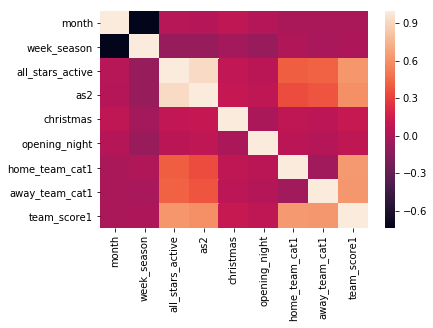

In [65]:
col = ['month','dow', 'week_season', 'all_stars_active', 'as2','christmas', 'opening_night', 'home_team_cat1', 'away_team_cat1', 'team_score1']
sns.heatmap(df[col].corr())
plt.show()

# Building a Regression

In [66]:
df.shape

(2000, 19)

In [67]:
#Creating Dummy
week_season_dummies = pd.get_dummies(df.week_season, prefix='week_season')

#Drop Dummy
week_season_dummies.drop(week_season_dummies.columns[0], axis=1, inplace=True)

#Concatenate

df = pd.concat([df, week_season_dummies], axis=1)
df.sample(n=5, random_state=1)

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow,week_season,...,week_season_17,week_season_18,week_season_19,week_season_20,week_season_21,week_season_22,week_season_23,week_season_24,week_season_25,week_season_26
game_id,,,,,,,,,,,,,,,,,,,,,
21600834,2016-17,2017-02-15,SAS,ORL,1,9335,2,7,Wednesday,17,...,1,0,0,0,0,0,0,0,0,0
21700851,2017-18,2018-02-13,SAC,DAL,0,4306,2,7,Tuesday,18,...,0,1,0,0,0,0,0,0,0,0
21700326,2017-18,2017-12-02,PHX,BOS,2,18962,12,48,Saturday,7,...,0,0,0,0,0,0,0,0,0,0
21700367,2017-18,2017-12-08,CHI,CHA,1,14264,12,49,Friday,8,...,0,0,0,0,0,0,0,0,0,0
21700244,2017-18,2017-11-20,UTA,PHI,1,17194,11,47,Monday,6,...,0,0,0,0,0,0,0,0,0,0


In [68]:
#Creating Dummy
dow_dummies = pd.get_dummies(df.day_num, prefix='dow')

#Drop Dummy
dow_dummies.drop(dow_dummies.columns[0], axis=1, inplace=True)

#Concatenate

df = pd.concat([df, dow_dummies], axis=1)
df.sample(n=5, random_state=1)

,season,game_date,away_team,home_team,all_stars_active,viewers,month,week,dow,week_season,...,week_season_23,week_season_24,week_season_25,week_season_26,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
game_id,,,,,,,,,,,,,,,,,,,,,
21600834,2016-17,2017-02-15,SAS,ORL,1,9335,2,7,Wednesday,17,...,0,0,0,0,0,1,0,0,0,0
21700851,2017-18,2018-02-13,SAC,DAL,0,4306,2,7,Tuesday,18,...,0,0,0,0,1,0,0,0,0,0
21700326,2017-18,2017-12-02,PHX,BOS,2,18962,12,48,Saturday,7,...,0,0,0,0,0,0,0,0,1,0
21700367,2017-18,2017-12-08,CHI,CHA,1,14264,12,49,Friday,8,...,0,0,0,0,0,0,0,1,0,0
21700244,2017-18,2017-11-20,UTA,PHI,1,17194,11,47,Monday,6,...,0,0,0,0,0,0,0,0,0,0


In [69]:
print(df.columns)
print(df.shape)

Index(['season', 'game_date', 'away_team', 'home_team', 'all_stars_active',
       'viewers', 'month', 'week', 'dow', 'week_season', 'day_num',
       'home_team_cat1', 'away_team_cat1', 'home_team1_^3', 'away_team1_^3',
       'team_score1', 'as2', 'christmas', 'opening_night', 'week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7'],
      dtype='object')
(2000, 50)


#### Linear Regression

In [70]:
from sklearn import metrics
# null accuracy if prediction was average viewers
df['viewers_avg'] = df.viewers.mean()
metrics.mean_absolute_error(df.viewers, df.viewers_avg)

8150.2289419999988

In [71]:
# define a function that accepts a list of features and returns testing RMSE
def train_test_mae(feature_cols):
    X = df[feature_cols]
    y = df.viewers
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    return metrics.mean_absolute_error(y_test, y_pred)

In [72]:
#all stars and team score1
print(train_test_mae(['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'team_score1']))

#all stars and home/away team categories
print(train_test_mae(['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']))


#as2 and team score1
print(train_test_mae(['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'team_score1']))


#as2, home/away team ^3
print(train_test_mae(['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']))

#as2 and home/away team categories
print(train_test_mae(['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team_cat1', 'away_team_cat1']))

4066.78862225
4066.15300997
3976.86773068
3976.16026276
4664.60746366


In [73]:
linreg = LinearRegression()

feature_cols = ['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'team_score1']

X = df[feature_cols]
y =df.viewers

scores = cross_val_score(linreg, X,y, cv=10, scoring = 'neg_mean_absolute_error')
np.mean(-scores)

4350.7439213674788

In [74]:
feature_cols = ['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']

X = df[feature_cols]
y =df.viewers

scores = cross_val_score(linreg, X,y, cv=10, scoring = 'neg_mean_absolute_error')
np.mean(-scores)

4346.7812464908102

In [75]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']

X = df[feature_cols]
y =df.viewers

scores = cross_val_score(linreg, X,y, cv=10, scoring = 'neg_mean_absolute_error')
np.mean(-scores)

4255.1098165739368

In [76]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7','team_score1']

X = df[feature_cols]
y =df.viewers

scores = cross_val_score(linreg, X,y, cv=10, scoring = 'neg_mean_absolute_error')
np.mean(-scores)

4254.366285917672

In [77]:
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats


X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                viewers   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     172.3
Date:                Thu, 20 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:45:48   Log-Likelihood:                -20028.
No. Observations:                2000   AIC:                         4.013e+04
Df Residuals:                    1964   BIC:                         4.033e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.765e+04    774.863     22.

In [78]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7','team_score1']

X = df[feature_cols]
y =df.viewers

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

metrics.mean_absolute_error(y_test, y_pred)

3976.8677306758836

#### KNN

In [79]:
from sklearn.neighbors import KNeighborsRegressor

feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7','team_score1']
X = df[feature_cols]
y=df.viewers

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(metrics.mean_absolute_error(y_test, y_pred))

6779.194


In [80]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7','team_score1']
X = df[feature_cols]
y=df.viewers
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

errors = []
for k in range(1,100):
    
    # instanitate knn
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # fit
    knn.fit(X_train, y_train)
    
    # predict (use the variable name pred)
    y_pred=knn.predict(X_test)
    
    # calculate the accuracy
    error = metrics.mean_absolute_error(y_test, y_pred)
    
    # append the accuracy to the scores
    errors.append([k, error])

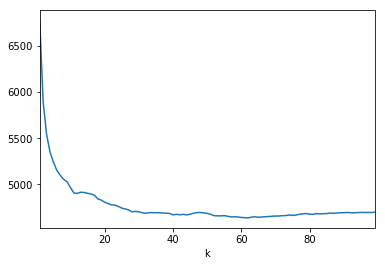

In [81]:
data = pd.DataFrame(errors, columns=['k', 'error'])
data.plot(x='k', y='error', legend=False)
plt.show()

In [82]:
data.sort_values(by='error').iloc[0]

k          62.000000
error    4635.100032
Name: 61, dtype: float64

In [83]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']

X = df[feature_cols]
y=df.viewers
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

errors = []
for k in range(1,100):
    
    # instanitate knn
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # fit
    knn.fit(X_train, y_train)
    
    # predict (use the variable name pred)
    y_pred=knn.predict(X_test)
    
    # calculate the accuracy
    error = metrics.mean_absolute_error(y_test, y_pred)
    
    # append the accuracy to the scores
    errors.append([k, error])
    
data = pd.DataFrame(errors, columns=['k', 'error'])
data.sort_values(by='error').iloc[0]

k          38.000000
error    4633.013842
Name: 37, dtype: float64

In [84]:
feature_cols = ['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']

X = df[feature_cols]
y=df.viewers
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

errors = []
for k in range(1,100):
    
    # instanitate knn
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # fit
    knn.fit(X_train, y_train)
    
    # predict (use the variable name pred)
    y_pred=knn.predict(X_test)
    
    # calculate the accuracy
    error = metrics.mean_absolute_error(y_test, y_pred)
    
    # append the accuracy to the scores
    errors.append([k, error])
    
data = pd.DataFrame(errors, columns=['k', 'error'])
data.sort_values(by='error').iloc[0]

k          38.000000
error    4632.419684
Name: 37, dtype: float64

In [85]:
feature_cols = ['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'team_score1']

X = df[feature_cols]
y=df.viewers
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

errors = []
for k in range(1,100):
    
    # instanitate knn
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # fit
    knn.fit(X_train, y_train)
    
    # predict (use the variable name pred)
    y_pred=knn.predict(X_test)
    
    # calculate the accuracy
    error = metrics.mean_absolute_error(y_test, y_pred)
    
    # append the accuracy to the scores
    errors.append([k, error])
    
data = pd.DataFrame(errors, columns=['k', 'error'])
data.sort_values(by='error').iloc[0]

k          62.000000
error    4635.787871
Name: 61, dtype: float64

In [86]:
feature_cols = ['all_stars_active','christmas', 'opening_night','week_season_2',
       'week_season_3', 'week_season_4', 'week_season_5', 'week_season_6',
       'week_season_7', 'week_season_8', 'week_season_9', 'week_season_10',
       'week_season_11', 'week_season_12', 'week_season_13', 'week_season_14',
       'week_season_15', 'week_season_16', 'week_season_17', 'week_season_18',
       'week_season_19', 'week_season_20', 'week_season_21', 'week_season_22',
       'week_season_23', 'week_season_24', 'week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6',
    'dow_7', 'home_team1_^3', 'away_team1_^3']
X = df[feature_cols]
y=df.viewers


knn = KNeighborsRegressor(n_neighbors=38)
scores = cross_val_score(knn, X,y, cv=10, scoring= 'neg_mean_absolute_error')
np.mean(-scores)

4884.1443289473682

#### Decision Trees

In [87]:
from sklearn.tree import DecisionTreeRegressor

feature_cols = [ 'christmas', 'opening_night','day_num', 'week_season', 'all_stars_active', 'team_score1']
X=df[feature_cols]
y=df.viewers

treereg = DecisionTreeRegressor(max_depth = 6, random_state=1)

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_absolute_error')
np.mean(-scores)

/Users/SBG/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


4448.4903263118076

In [88]:
treereg.fit(X,y)
pd.DataFrame(list(zip(feature_cols,treereg.feature_importances_)))

,0,1
0,christmas,0.000025
1,opening_night,0.000599
2,day_num,0.008923
3,week_season,0.136178
4,all_stars_active,0.029001
5,team_score1,0.825273


In [89]:
from sklearn.model_selection import GridSearchCV
depth = list(range(1, 10))
param_grid = dict(max_depth=depth)
grid = GridSearchCV(treereg, param_grid, cv=10, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
grid.fit(X,y)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-4448.49032631
{'max_depth': 6}
DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')


In [90]:
from sklearn.tree import DecisionTreeRegressor

feature_cols = [ 'christmas', 'opening_night','day_num', 'week_season', 'as2', 'team_score1']
X=df[feature_cols]
y=df.viewers

treereg = DecisionTreeRegressor(max_depth = 6, random_state=1)

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_absolute_error')
np.mean(-scores)

4448.4903263118076

 # Making Predictions

In [91]:
test = pd.read_csv(test_set)
test.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600010,10/26/2016,DEN,NOP,NaN
1,2016-17,21600023,10/28/2016,HOU,DAL,NaN
2,2016-17,21600027,10/29/2016,BOS,CHA,NaN
3,2016-17,21600026,10/29/2016,ATL,PHI,NaN
4,2016-17,21600048,11/1/2016,LAL,IND,NaN


In [92]:
test.columns = [x.lower() for x in test.columns]

In [93]:
test.columns

Index(['season', 'game_id', 'game_date', 'away_team', 'home_team',
       'total_viewers'],
      dtype='object')

In [94]:
all_stars.head()

,game_id,all_stars_active
0,21600001,4
1,21600002,0
2,21600003,5
3,21600004,0
4,21600005,1


In [95]:
df = pd.merge(test, all_stars)

#rename to viewers and drop rounded viewers

df.set_index('game_id', inplace=True)
df.drop('total_viewers', axis=1, inplace=True)
df.head()

,season,game_date,away_team,home_team,all_stars_active
game_id,,,,,
21600010,2016-17,10/26/2016,DEN,NOP,1
21600023,2016-17,10/28/2016,HOU,DAL,1
21600027,2016-17,10/29/2016,BOS,CHA,2
21600026,2016-17,10/29/2016,ATL,PHI,1
21600048,2016-17,11/1/2016,LAL,IND,1


In [96]:
df.shape

(460, 5)

In [97]:
# Convert game_date to datetime
df['game_date'] = pd.to_datetime(df.game_date)

# Create seperate columns for month and day of the week
df['month'], df['week'], df['dow'] = df.game_date.dt.month, df.game_date.dt.week, df.game_date.dt.weekday_name

df.head(10)

,season,game_date,away_team,home_team,all_stars_active,month,week,dow
game_id,,,,,,,,
21600010,2016-17,2016-10-26,DEN,NOP,1,10,43,Wednesday
21600023,2016-17,2016-10-28,HOU,DAL,1,10,43,Friday
21600027,2016-17,2016-10-29,BOS,CHA,2,10,43,Saturday
21600026,2016-17,2016-10-29,ATL,PHI,1,10,43,Saturday
21600048,2016-17,2016-11-01,LAL,IND,1,11,44,Tuesday
21600053,2016-17,2016-11-01,UTA,SAS,1,11,44,Tuesday
21600050,2016-17,2016-11-01,NYK,DET,1,11,44,Tuesday
21600049,2016-17,2016-11-01,SAC,MIA,1,11,44,Tuesday
21600061,2016-17,2016-11-02,CHI,BOS,2,11,44,Wednesday


In [98]:
df['christmas'] = np.where((df['game_date'] == '2016-12-25') | (df['game_date'] == '2017-12-25'), 1,0)
df['opening_night'] = np.where(((df['season'] == '2016-17') & (df['game_date'] == ' 2016-10-25')) | ((df['season'] == '2017-18') & (df['game_date'] == ' 2017-10-17')),1,0)


In [99]:
conditions = [(df['week'] == 43) & (df['season'] == '2016-17'),(df['week'] == 44) & (df['season'] == '2016-17'),
(df['week'] == 45) & (df['season'] == '2016-17'),(df['week'] == 46) & (df['season'] == '2016-17'),
(df['week'] == 47) & (df['season'] == '2016-17'),(df['week'] == 48) & (df['season'] == '2016-17'),
(df['week'] == 49) & (df['season'] == '2016-17'),(df['week'] == 50) & (df['season'] == '2016-17'),
(df['week'] == 51) & (df['season'] == '2016-17'),(df['week'] == 52) & (df['season'] == '2016-17'),
(df['week'] == 1) & (df['season'] == '2016-17'),(df['week'] == 2) & (df['season'] == '2016-17'),
(df['week'] == 3) & (df['season'] == '2016-17'),(df['week'] == 4) & (df['season'] == '2016-17'),
(df['week'] == 5) & (df['season'] == '2016-17'),(df['week'] == 6) & (df['season'] == '2016-17'),
(df['week'] == 7) & (df['season'] == '2016-17'),(df['week'] == 8) & (df['season'] == '2016-17'),
(df['week'] == 9) & (df['season'] == '2016-17'),(df['week'] == 10) & (df['season'] == '2016-17'),
(df['week'] == 11) & (df['season'] == '2016-17'),(df['week'] == 12) & (df['season'] == '2016-17'),
(df['week'] == 13) & (df['season'] == '2016-17'),(df['week'] == 14) & (df['season'] == '2016-17'),
(df['week'] == 15) & (df['season'] == '2016-17'),(df['week'] == 42) & (df['season'] == '2017-18'),
(df['week'] == 43) & (df['season'] == '2017-18'),(df['week'] == 44) & (df['season'] == '2017-18'),
(df['week'] == 45) & (df['season'] == '2017-18'),(df['week'] == 46) & (df['season'] == '2017-18'),
(df['week'] == 47) & (df['season'] == '2017-18'),(df['week'] == 48) & (df['season'] == '2017-18'),
(df['week'] == 49) & (df['season'] == '2017-18'),(df['week'] == 50) & (df['season'] == '2017-18'),
(df['week'] == 51) & (df['season'] == '2017-18'),(df['week'] == 52) & (df['season'] == '2017-18'),
(df['week'] == 1) & (df['season'] == '2017-18'),(df['week'] == 2) & (df['season'] == '2017-18'),
(df['week'] == 3) & (df['season'] == '2017-18'),(df['week'] == 4) & (df['season'] == '2017-18'),
(df['week'] == 5) & (df['season'] == '2017-18'),(df['week'] == 6) & (df['season'] == '2017-18'),
(df['week'] == 7) & (df['season'] == '2017-18'),(df['week'] == 8) & (df['season'] == '2017-18'),
(df['week'] == 9) & (df['season'] == '2017-18'),(df['week'] == 10) & (df['season'] == '2017-18'),
(df['week'] == 11) & (df['season'] == '2017-18'),(df['week'] == 12) & (df['season'] == '2017-18'),
(df['week'] == 13) & (df['season'] == '2017-18'),(df['week'] == 14) & (df['season'] == '2017-18'),
(df['week'] == 15) & (df['season'] == '2017-18')]
    
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
df['week_season'] = np.select(conditions, choices, default =0)

In [100]:
df['day_num'] = df.dow.map({'Monday': 1, 'Tuesday':2, 'Wednesday': 3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday': 7})
df['as2'] = df.all_stars_active * df.all_stars_active



In [101]:
conditions = [(df['home_team'] == 'CLE') & (df['season'] == '2017-18'),(df['home_team'] == 'GSW') & (df['season'] == '2016-17'),
             (df['home_team'] == 'GSW') & (df['season'] == '2017-18'),(df['home_team'] == 'CLE') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BOS') & (df['season'] == '2017-18'),(df['home_team'] == 'OKC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'LAL') & (df['season'] == '2017-18'),(df['home_team'] == 'OKC') & (df['season'] == '2016-17'),
             (df['home_team'] == 'PHI') & (df['season'] == '2017-18'),(df['home_team'] == 'SAS') & (df['season'] == '2016-17'),
             (df['home_team'] == 'HOU') & (df['season'] == '2017-18'),(df['home_team'] == 'NYK') & (df['season'] == '2016-17'),
             (df['home_team'] == 'HOU') & (df['season'] == '2016-17'),(df['home_team'] == 'LAL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BOS') & (df['season'] == '2016-17'),(df['home_team'] == 'CHI') & (df['season'] == '2016-17'),
             (df['home_team'] == 'SAS') & (df['season'] == '2017-18'),(df['home_team'] == 'MIN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'LAC') & (df['season'] == '2016-17'),(df['home_team'] == 'TOR') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MIL') & (df['season'] == '2017-18'),(df['home_team'] == 'TOR') & (df['season'] == '2016-17'),
             (df['home_team'] == 'MIN') & (df['season'] == '2016-17'),(df['home_team'] == 'WAS') & (df['season'] == '2017-18'),
             (df['home_team'] == 'PHI') & (df['season'] == '2016-17'),(df['home_team'] == 'POR') & (df['season'] == '2016-17'),
             (df['home_team'] == 'NYK') & (df['season'] == '2017-18'),(df['home_team'] == 'NOP') & (df['season'] == '2017-18'),
             (df['home_team'] == 'NOP') & (df['season'] == '2016-17'),(df['home_team'] == 'POR') & (df['season'] == '2017-18'),
             (df['home_team'] == 'DET') & (df['season'] == '2017-18'),(df['home_team'] == 'WAS') & (df['season'] == '2016-17'),
             (df['home_team'] == 'MIL') & (df['season'] == '2016-17'),(df['home_team'] == 'MIA') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MIA') & (df['season'] == '2016-17'),(df['home_team'] == 'LAC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'ATL') & (df['season'] == '2016-17'),(df['home_team'] == 'IND') & (df['season'] == '2017-18'),
             (df['home_team'] == 'CHA') & (df['season'] == '2016-17'),(df['home_team'] == 'PHX') & (df['season'] == '2016-17'),
             (df['home_team'] == 'CHI') & (df['season'] == '2017-18'),(df['home_team'] == 'DEN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'SAC') & (df['season'] == '2016-17'),(df['home_team'] == 'UTA') & (df['season'] == '2016-17'),
             (df['home_team'] == 'UTA') & (df['season'] == '2017-18'),(df['home_team'] == 'IND') & (df['season'] == '2016-17'),
             (df['home_team'] == 'BKN') & (df['season'] == '2016-17'),(df['home_team'] == 'BKN') & (df['season'] == '2017-18'),
             (df['home_team'] == 'CHA') & (df['season'] == '2017-18'),(df['home_team'] == 'DAL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'ORL') & (df['season'] == '2017-18'),(df['home_team'] == 'DAL') & (df['season'] == '2017-18'),
             (df['home_team'] == 'MEM') & (df['season'] == '2016-17'),(df['home_team'] == 'ORL') & (df['season'] == '2016-17'),
             (df['home_team'] == 'DEN') & (df['season'] == '2016-17'),(df['home_team'] == 'ATL') & (df['season'] == '2017-18'),
             (df['home_team'] == 'DET') & (df['season'] == '2016-17'),(df['home_team'] == 'SAC') & (df['season'] == '2017-18'),
             (df['home_team'] == 'PHX') & (df['season'] == '2017-18'),(df['home_team'] == 'MEM') & (df['season'] == '2017-18')]
             


choices = [60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
df['home_team_cat1'] = np.select(conditions, choices, default=0)

In [102]:
conditions = [(df['away_team'] == 'CLE') & (df['season'] == '2017-18'),
             (df['away_team'] == 'GSW') & (df['season'] == '2016-17'),(df['away_team'] == 'GSW') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CLE') & (df['season'] == '2016-17'),(df['away_team'] == 'BOS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'OKC') & (df['season'] == '2017-18'),(df['away_team'] == 'LAL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'OKC') & (df['season'] == '2016-17'),(df['away_team'] == 'PHI') & (df['season'] == '2017-18'),
             (df['away_team'] == 'SAS') & (df['season'] == '2016-17'),(df['away_team'] == 'HOU') & (df['season'] == '2017-18'),
             (df['away_team'] == 'NYK') & (df['season'] == '2016-17'),(df['away_team'] == 'HOU') & (df['season'] == '2016-17'),
             (df['away_team'] == 'LAL') & (df['season'] == '2016-17'),(df['away_team'] == 'BOS') & (df['season'] == '2016-17'),
             (df['away_team'] == 'CHI') & (df['season'] == '2016-17'),(df['away_team'] == 'SAS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MIN') & (df['season'] == '2017-18'),(df['away_team'] == 'LAC') & (df['season'] == '2016-17'),
             (df['away_team'] == 'TOR') & (df['season'] == '2017-18'),(df['away_team'] == 'MIL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'TOR') & (df['season'] == '2016-17'),
             (df['away_team'] == 'MIN') & (df['season'] == '2016-17'),(df['away_team'] == 'WAS') & (df['season'] == '2017-18'),
             (df['away_team'] == 'PHI') & (df['season'] == '2016-17'),(df['away_team'] == 'POR') & (df['season'] == '2016-17'),
             (df['away_team'] == 'NYK') & (df['season'] == '2017-18'),(df['away_team'] == 'NOP') & (df['season'] == '2017-18'),
             (df['away_team'] == 'NOP') & (df['season'] == '2016-17'),(df['away_team'] == 'POR') & (df['season'] == '2017-18'),
             (df['away_team'] == 'DET') & (df['season'] == '2017-18'),(df['away_team'] == 'WAS') & (df['season'] == '2016-17'),
             (df['away_team'] == 'MIL') & (df['season'] == '2016-17'),(df['away_team'] == 'MIA') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MIA') & (df['season'] == '2016-17'),(df['away_team'] == 'LAC') & (df['season'] == '2017-18'),
             (df['away_team'] == 'ATL') & (df['season'] == '2016-17'),(df['away_team'] == 'IND') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CHA') & (df['season'] == '2016-17'),(df['away_team'] == 'PHX') & (df['season'] == '2016-17'),
             (df['away_team'] == 'CHI') & (df['season'] == '2017-18'),(df['away_team'] == 'DEN') & (df['season'] == '2017-18'),
             (df['away_team'] == 'SAC') & (df['season'] == '2016-17'),(df['away_team'] == 'UTA') & (df['season'] == '2016-17'),
             (df['away_team'] == 'UTA') & (df['season'] == '2017-18'),(df['away_team'] == 'IND') & (df['season'] == '2016-17'),
             (df['away_team'] == 'BKN') & (df['season'] == '2016-17'),(df['away_team'] == 'BKN') & (df['season'] == '2017-18'),
             (df['away_team'] == 'CHA') & (df['season'] == '2017-18'),(df['away_team'] == 'DAL') & (df['season'] == '2016-17'),
             (df['away_team'] == 'ORL') & (df['season'] == '2017-18'),(df['away_team'] == 'DAL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'MEM') & (df['season'] == '2016-17'),(df['away_team'] == 'ORL') & (df['season'] == '2016-17'),
             (df['away_team'] == 'DEN') & (df['season'] == '2016-17'),(df['away_team'] == 'ATL') & (df['season'] == '2017-18'),
             (df['away_team'] == 'DET') & (df['season'] == '2016-17'),(df['away_team'] == 'SAC') & (df['season'] == '2017-18'),
             (df['away_team'] == 'PHX') & (df['season'] == '2017-18'),(df['away_team'] == 'MEM') & (df['season'] == '2017-18')]
             


choices = [60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

df['away_team_cat1'] = np.select(conditions, choices, default=0)

In [103]:
df['home_team1_^3'] = df['home_team_cat1'] * df['home_team_cat1'] * df['home_team_cat1']
df['away_team1_^3'] = df['away_team_cat1'] * df['away_team_cat1'] * df['away_team_cat1']
df['team_score1'] = df['home_team1_^3'] + df['away_team1_^3']

In [104]:
df.head()

,season,game_date,away_team,home_team,all_stars_active,month,week,dow,christmas,opening_night,week_season,day_num,as2,home_team_cat1,away_team_cat1,home_team1_^3,away_team1_^3,team_score1
game_id,,,,,,,,,,,,,,,,,,
21600010,2016-17,2016-10-26,DEN,NOP,1,10,43,Wednesday,0,0,1,3,1,32,6,32768,216,32984
21600023,2016-17,2016-10-28,HOU,DAL,1,10,43,Friday,0,0,1,5,1,11,48,1331,110592,111923
21600027,2016-17,2016-10-29,BOS,CHA,2,10,43,Saturday,0,0,1,6,4,22,46,10648,97336,107984
21600026,2016-17,2016-10-29,ATL,PHI,1,10,43,Saturday,0,0,1,6,1,36,24,46656,13824,60480
21600048,2016-17,2016-11-01,LAL,IND,1,11,44,Tuesday,0,0,2,2,1,15,47,3375,103823,107198


In [105]:
#Creating Dummy
week_season_dummies = pd.get_dummies(df.week_season, prefix='week_season')

#Drop Dummy
week_season_dummies.drop(week_season_dummies.columns[0], axis=1, inplace=True)

#Concatenate

df = pd.concat([df, week_season_dummies], axis=1)

In [106]:
#Creating Dummy
dow_dummies = pd.get_dummies(df.day_num, prefix='dow')

#Drop Dummy
dow_dummies.drop(dow_dummies.columns[0], axis=1, inplace=True)

#Concatenate

df = pd.concat([df, dow_dummies], axis=1)

In [107]:
print(df.columns)
print(df.shape)

Index(['season', 'game_date', 'away_team', 'home_team', 'all_stars_active',
       'month', 'week', 'dow', 'christmas', 'opening_night', 'week_season',
       'day_num', 'as2', 'home_team_cat1', 'away_team_cat1', 'home_team1_^3',
       'away_team1_^3', 'team_score1', 'week_season_2', 'week_season_3',
       'week_season_4', 'week_season_5', 'week_season_6', 'week_season_7',
       'week_season_8', 'week_season_9', 'week_season_10', 'week_season_11',
       'week_season_12', 'week_season_13', 'week_season_14', 'week_season_15',
       'week_season_16', 'week_season_17', 'week_season_18', 'week_season_19',
       'week_season_20', 'week_season_21', 'week_season_22', 'week_season_23',
       'week_season_24', 'week_season_25', 'week_season_26', 'dow_2', 'dow_3',
       'dow_4', 'dow_5', 'dow_6', 'dow_7'],
      dtype='object')
(460, 49)


In [108]:
feature_cols = ['as2','christmas', 'opening_night','week_season_2', 'week_season_3', 'week_season_4','week_season_5', 
                'week_season_6', 'week_season_7', 'week_season_8','week_season_9', 'week_season_10', 'week_season_11',
                'week_season_12','week_season_13', 'week_season_14', 'week_season_15', 'week_season_16','week_season_17',
                'week_season_18', 'week_season_19', 'week_season_20','week_season_21', 'week_season_22', 'week_season_23',
                'week_season_24','week_season_25', 'week_season_26','dow_2','dow_3','dow_4','dow_5','dow_6','dow_7', 'team_score1']

X = df[feature_cols]
df['viewers'] = linreg.predict(X)
df['viewers'] = df['viewers'].astype('int')

In [109]:
df[['season', 'game_date', 'all_stars_active','away_team', 'home_team', 'week_season', 'viewers']]

,season,game_date,all_stars_active,away_team,home_team,week_season,viewers
game_id,,,,,,,
21600010,2016-17,2016-10-26,1,DEN,NOP,1,19187
21600023,2016-17,2016-10-28,1,HOU,DAL,1,27466
21600027,2016-17,2016-10-29,2,BOS,CHA,1,28510
21600026,2016-17,2016-10-29,1,ATL,PHI,1,23626
21600048,2016-17,2016-11-01,1,LAL,IND,2,22692
21600053,2016-17,2016-11-01,1,UTA,SAS,2,25060
21600050,2016-17,2016-11-01,1,NYK,DET,2,23512
21600049,2016-17,2016-11-01,1,SAC,MIA,2,16156
21600061,2016-17,2016-11-02,2,CHI,BOS,2,27669


In [110]:
df.viewers.describe()

count      460.000000
mean     17022.478261
std       9314.189520
min       1274.000000
25%       9806.750000
50%      15383.000000
75%      22671.000000
max      72069.000000
Name: viewers, dtype: float64

In [111]:
over_30k=df[df['viewers'] >30000]
over_30k[['game_date', 'away_team', 'home_team', 'all_stars_active', 'viewers']].sort_values(by='viewers',ascending=False)

,game_date,away_team,home_team,all_stars_active,viewers
game_id,,,,,
21700002,2017-10-17,HOU,GSW,5,72069
21600069,2016-11-03,OKC,GSW,5,52991
21700646,2018-01-15,GSW,CLE,6,52031
21700559,2018-01-03,CLE,BOS,4,42169
21700679,2018-01-20,GSW,HOU,5,41596
21600796,2017-02-09,CLE,OKC,4,39714
21700631,2018-01-13,GSW,TOR,5,39572
21700614,2018-01-11,BOS,PHI,3,39197
21700835,2018-02-11,CLE,BOS,3,38916


In [112]:
under_10k=df[df['viewers'] < 10000]
under_10k[['game_date', 'away_team', 'home_team', 'all_stars_active', 'viewers']].sort_values(by='viewers',ascending=False)

,game_date,away_team,home_team,all_stars_active,viewers
game_id,,,,,
21701178,2018-04-05,BKN,MIL,1,9991
21700516,2017-12-28,DET,ORL,1,9986
21600304,2016-12-05,DEN,PHI,0,9845
21600631,2017-01-18,ORL,NOP,1,9834
21700618,2018-01-12,UTA,CHA,1,9827
21700525,2017-12-29,DAL,NOP,2,9827
21700162,2017-11-08,MIA,PHX,1,9746
21600315,2016-12-06,ORL,WAS,1,9743
21700685,2018-01-21,BKN,DET,1,9724


### More Thoughts

- After I built the model, check where the biggest differences were. Can I learn anything from that?
- More time after modeling finding the best parameters
- More feature engineering
- Explore Decision Trees more
- New tactics such as Gradient Boosting